## Event Analysis Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
from tabulate import tabulate
import networkx as nx
import analysis_functions
import random
import math
import numpy as np

In [2]:
### Load Data 
voteData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\votes.csv')
groupData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\users_to_groups.csv')
forumQuestions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\forum_questions.csv')
groupCategories = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\group_categories.csv')
questionOptions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\question_options.csv')

# print("voteData:", len(voteData))
# print("groupData:", len(groupData))
# print("forumQuestions:", len(forumQuestions))
# print("groupCategories:", len(groupCategories))

### Manual Analysis

In [3]:
# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# Specify an option id
option_id = '4ad65252-e651-460c-af6b-289769a3964b'

In [4]:
# Analysis of a given option id 
votes = analysis_functions.get_latest_vote_by_user_and_optionid(voteData, option_id)
filtered_votes = analysis_functions.filter_zero_votes(votes)
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, group_categories)
groups = analysis_functions.get_groups_by_user_and_optionid(groupData, filtered_votes, group_categories_ids)
memberships = analysis_functions.create_group_memberships(groups)
filtered_groups = analysis_functions.remove_duplicate_groups(groups)
plurality_score = analysis_functions.connection_oriented_cluster_match(filtered_groups, filtered_votes)

# print("votes:", votes)
# print("filtered_votes:", filtered_votes)
# print("group_categories_ids:", group_categories_ids)
# print("groups:", groups)
# print("memberships:", memberships)
# print("filtered_groups:", filtered_groups)
# print("plurality_score:", plurality_score)

### Voting Results Table  

In [5]:
# specify a question id 
question_id = '5eaea820-8b02-446c-bf17-59f6fc1799bc'

# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# get list of option ids related to the question id 
optionIds = questionOptions[questionOptions['question_id'] == question_id]['id'].tolist()

In [6]:
# Generate Results 
results_dict = analysis_functions.get_results_dict(optionIds, voteData, groupData, groupCategories, group_categories)

# add a rank to each result category (plural score, raw votes, quadratic score)
results_dict_with_ranks = analysis_functions.calculate_ranks(results_dict)

# Sort results according to the plurality score
sorted_results_dict_with_ranks = dict(sorted(results_dict_with_ranks.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [7]:
# Create data table 
table_data = []
headers = ['Options', 'Plurality Score', 'Quadratic Score', 'Raw Votes']

option_counter = 1

for option, data in sorted_results_dict_with_ranks.items():
    row = [f'Option {option_counter}']
    for category in ['pluralityScore', 'quadraticScore', 'totalRawVotes']:
        row.append(round(data[category]['score'], 3))
    table_data.append(row)
    option_counter += 1 

df = pd.DataFrame(table_data, columns=headers)

In [8]:
# Save and Print results 
df.to_excel('plots-and-tables/voting_results.xlsx', index=False)
print(tabulate(df, headers='keys', tablefmt='pretty'))

+----+-----------+-----------------+-----------------+-----------+
|    |  Options  | Plurality Score | Quadratic Score | Raw Votes |
+----+-----------+-----------------+-----------------+-----------+
| 0  | Option 1  |      59.45      |     64.658      |    213    |
| 1  | Option 2  |     42.394      |     43.858      |    196    |
| 2  | Option 3  |     39.655      |     50.425      |    263    |
| 3  | Option 4  |     38.545      |     41.391      |    124    |
| 4  | Option 5  |     36.083      |     37.335      |    124    |
| 5  | Option 6  |     36.031      |     37.566      |    110    |
| 6  | Option 7  |     32.766      |     31.035      |    82     |
| 7  | Option 8  |      30.99      |     32.565      |    86     |
| 8  | Option 9  |     27.541      |     28.423      |    60     |
| 9  | Option 10 |     27.254      |     28.397      |    82     |
| 10 | Option 11 |     25.808      |     25.104      |    64     |
| 11 | Option 12 |     25.604      |      26.75      |    67  

### Result Visualizations

#### Ranking Distribution

In [9]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'quadraticScore', 'totalRawVotes']
custom_labels = ['Plurality Score Rank', 'Quadratic Score Rank', 'Raw Votes Rank']

# Get the number of options
num_options = len(sorted_results_dict_with_ranks)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

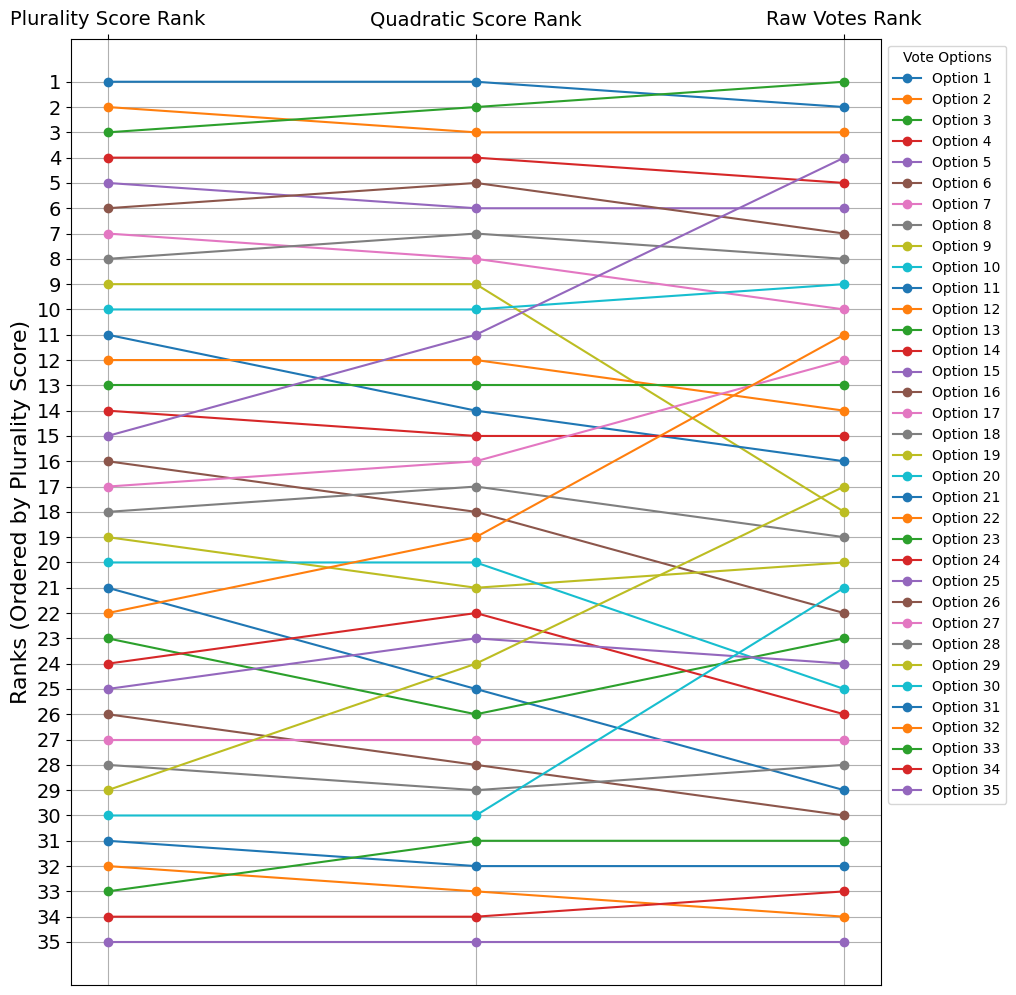

In [10]:
# Bump Chart 
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=colors[i])

plt.gca().invert_yaxis() 
plt.yticks(range(1, max(ranks) + 1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels)
plt.tight_layout()
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart.png')

#### Highlighted Ranking Distribution

In [11]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_results_dict_with_ranks.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

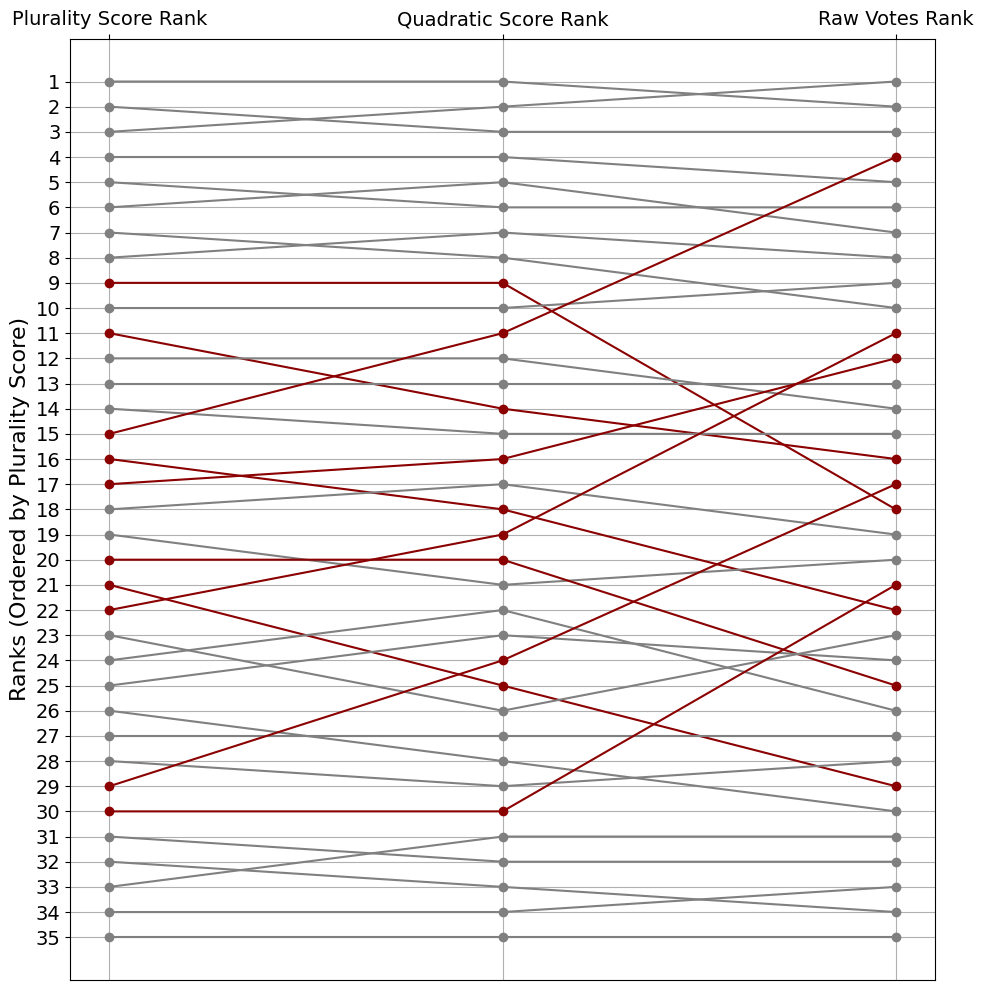

In [12]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 4:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_without_legend.png')

### Network Visualization

In [13]:
# filter group data by users who voted and by relevant group categories 
distinct_user_ids = voteData['user_id'].unique().tolist()
filtered_group_users = groupData[groupData['user_id'].isin(distinct_user_ids)]
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, names=['affiliation', 'private'])
filtered_group_users_categories = filtered_group_users[filtered_group_users['group_category_id'].isin(group_categories_ids)]

print("Number of unique users:", filtered_group_users['user_id'].nunique())
print("Number of group categories:", filtered_group_users_categories['group_category_id'].nunique())
print("Length of group data:", len(filtered_group_users_categories))

Number of unique users: 36
Number of group categories: 2
Length of group data: 60


In [14]:
# Group by 'user_id' and aggregate 'group_id' and 'group_category_id' into lists
reduced_filtered_group_users_categories = filtered_group_users_categories.groupby('user_id').agg({'group_id': list, 'group_category_id': list}).reset_index()
# reduced_filtered_group_users_categories.head()

In [15]:
# Get Network Nodes
all_user_ids = set(filtered_group_users_categories['user_id'])
node_list = [{'id': user_id} for user_id in all_user_ids]

# Get Network Edges
edge_list = []

grouped = filtered_group_users_categories.groupby('group_id')
for group_id, group_data in grouped:
    # Create pairs of users within the group
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            edge_list.append({'source': group_data.iloc[i]['user_id'], 'target': group_data.iloc[j]['user_id']})

edge_df = pd.DataFrame(edge_list)

In [16]:
# Create edge attribute highlighting the affiliation relationship between nodes 
 
merged_df = pd.merge(edge_df, reduced_filtered_group_users_categories, left_on='source', right_on='user_id', suffixes=('', '_source'))
merged_df = pd.merge(merged_df, reduced_filtered_group_users_categories, left_on='target', right_on='user_id', suffixes=('', '_target'))

# Define function to find common groups and group categories
def find_shared_groups_and_categories(row):
    source_groups = set(row['group_id'])
    target_groups = set(row['group_id_target'])
    shared_groups = source_groups.intersection(target_groups)
    
    shared_group_categories = []
    for group in shared_groups:
        source_category = row['group_category_id'][row['group_id'].index(group)]
        target_category = row['group_category_id_target'][row['group_id_target'].index(group)]
        if source_category == target_category:
            shared_group_categories.append(source_category)
        else:
            shared_group_categories.extend([source_category, target_category])
    
    return pd.Series([list(shared_groups), list(set(shared_group_categories))])

# Apply the function to each row and create new columns 'shared_groups' and 'shared_group_categories'
merged_df[['shared_groups', 'shared_group_categories']] = merged_df.apply(find_shared_groups_and_categories, axis=1)

# Define function to determine edge attribute
def determine_edge_attribute(shared_group_categories):
    shared_categories_set = set(shared_group_categories)
    if '0419db52-cda8-4cf2-adb2-a881234ea1f8' in shared_categories_set and 'b1862f74-458c-4eb8-9445-1ccf9ccd1712' in shared_categories_set:
        return 'both'
    elif shared_categories_set == {'0419db52-cda8-4cf2-adb2-a881234ea1f8'}:
        return 'affiliation'
    elif shared_categories_set == {'b1862f74-458c-4eb8-9445-1ccf9ccd1712'}:
        return 'private'
    return None

merged_df['edge_attribute'] = merged_df['shared_group_categories'].apply(determine_edge_attribute)

edge_df_new = merged_df[['source', 'target', 'edge_attribute']]
# edge_df_new.head()

In [17]:
# TODO: Need to look into duplicate edges (however no impact on results)
# duplicate_edges = edge_df_new[edge_df_new.duplicated(subset=['target', 'source'], keep=False)]
# duplicate_edges

# Sorting the values in each row to ensure the order doesn't matter
# edge_df_new[['source', 'target']] = pd.DataFrame(np.sort(edge_df_new[['source', 'target']], axis=1), index=edge_df_new.index)

# Finding duplicates
# duplicates = edge_df_new[edge_df_new.duplicated(subset=['source', 'target'], keep=False)]

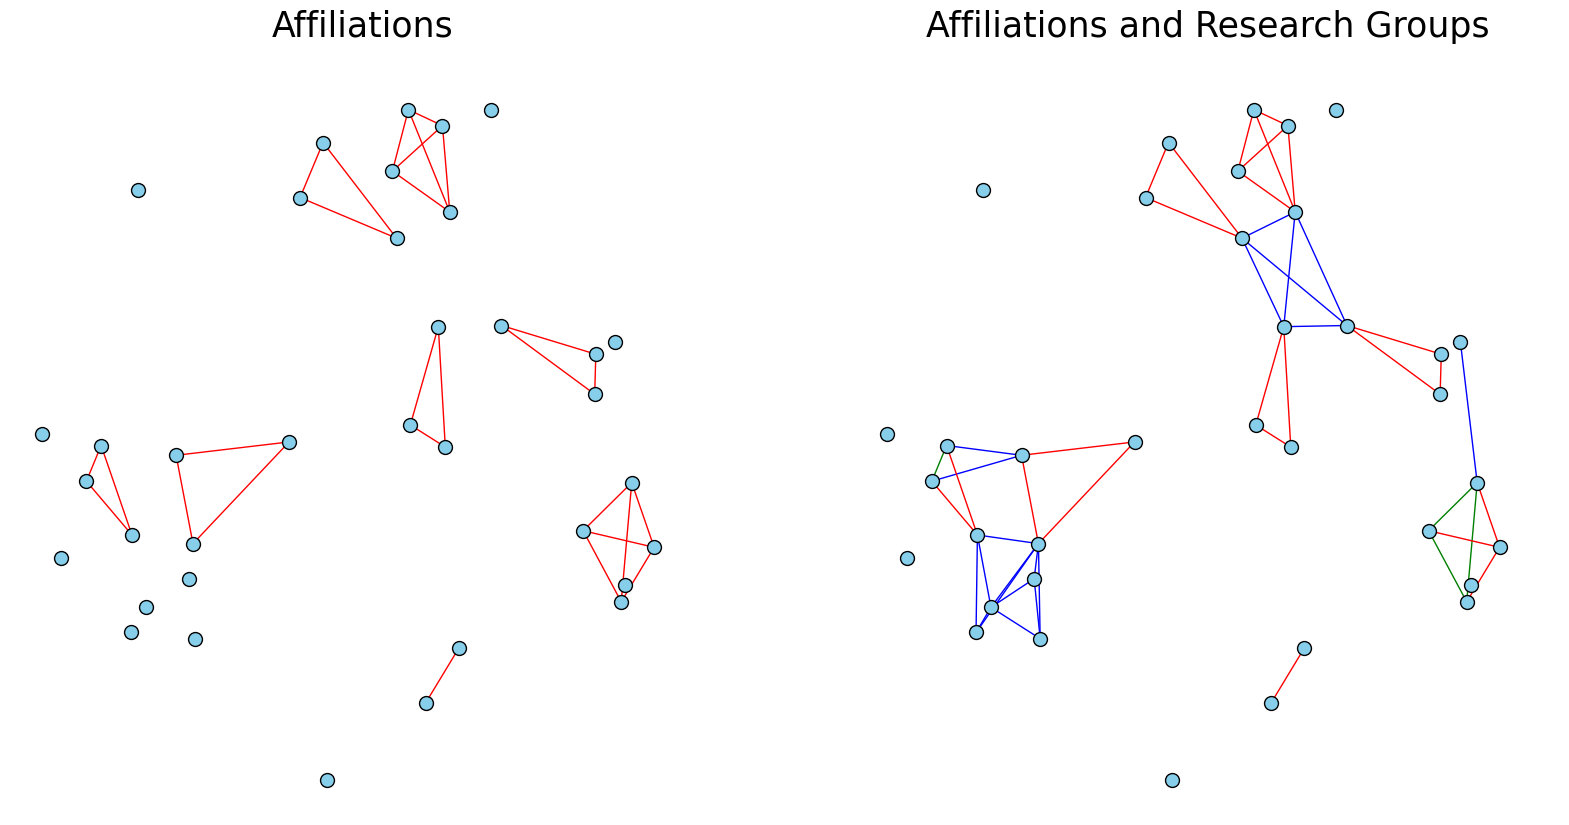

In [18]:
# Create network  plot
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 2: Edges colored based on their attributes using a colormap
G2 = nx.Graph()
G2.add_nodes_from([node['id'] for node in node_list])
for _, row in edge_df_new.iterrows():
    G2.add_edge(row['source'], row['target'], edge_attribute=row['edge_attribute'])

# Use the Fruchterman-Reingold layout for positioning nodes
pos = nx.fruchterman_reingold_layout(G2, k=4, iterations=500, scale=1.5, seed=6)

# Create a colormap based on edge attributes
edge_colors2 = []
edge_color_map = {'affiliation': 'red', 'private': 'blue', 'both': 'green'}
for edge in G2.edges():
    edge_attribute = G2[edge[0]][edge[1]]['edge_attribute']
    edge_colors2.append(edge_color_map[edge_attribute])

# Draw the network
nx.draw(G2, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color=edge_colors2, ax=axes[1])
axes[1].set_title('Affiliations and Research Groups', fontsize=25)

# Plot 1: Only "affiliation" and "both" edges, all in red
G1 = nx.Graph()
G1.add_nodes_from([node['id'] for node in node_list])
edges1 = [(row['source'], row['target']) for _, row in edge_df_new.iterrows() if row['edge_attribute'] in ['affiliation', 'both']]
G1.add_edges_from(edges1)

# Use the same layout positions as G2
pos = nx.fruchterman_reingold_layout(G1, pos=pos, fixed=pos.keys(), seed=6)

# Draw Graph 1 with red edges
nx.draw(G1, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color='red', ax=axes[0])
axes[0].set_title('Affiliations', fontsize=25)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/network.png')


### Network Simulation 

In [19]:
# Define the parameters
n = 100  # Number of nodes
p = 0.05  # Probability of edge creation
num_networks = 2
num_network_permutations = 20  # Number of network permutations 
edge_share_values = [0.1, 0.25, 0.5, 0.7, 0.8, 0.9] # Define the share of edges to remove

# Create the original ER network with the specified seed
er_networks = [nx.erdos_renyi_graph(n, p, seed=i) for i in range(num_networks)]

In [20]:
all_modified_networks = {}

# Iterate over each original network
for idx, er_network in enumerate(er_networks):
    # Initialize the dictionary to store modified networks for the current original network
    modified_networks = {}
    
    # Iterate over each edge share value
    for edge_share in edge_share_values:
        # Initialize a list to store modified networks for the current edge share
        modified_networks[edge_share] = []
        
        # Iterate for each network
        for i in range(1, num_network_permutations + 1):
            # Create a copy of the original network
            network_copy = er_network.copy()

            # Randomly choose edges to remove based on the current edge share
            edges_to_remove = random.sample(list(network_copy.edges()), int(edge_share * network_copy.number_of_edges()))

            # Remove the chosen edges from the graph
            network_copy.remove_edges_from(edges_to_remove)
            
            # Append the modified network to the list for the current edge share
            modified_networks[edge_share].append(network_copy)
    
    # Store the modified networks dictionary in the main dictionary
    all_modified_networks[f'network_{idx+1}'] = modified_networks

In [21]:
# Define a function to get the first-order connections of a node
def get_first_order_connections(graph, node):
    neighbors = set(graph.neighbors(node))
    neighbors.add(node)  # Add the node itself to its group
    return neighbors

In [22]:
all_groups = {}

# Iterate over each original network's modified networks
for network_key, modified_networks in all_modified_networks.items():
    all_groups[network_key] = {}
    
    # Loop through the modified networks and create groups
    for edge_share, networks in modified_networks.items():
        all_groups[network_key][edge_share] = {}  # Initialize a dictionary for this edge share value
        
        for idx, net in enumerate(networks):
            # Create groups based on first-order connections
            groups = {}
            for node in net.nodes:
                groups[node] = list(get_first_order_connections(net, node))

            # Store the groups in the dictionary for this network
            group_dict = {f"Group {node} {network_key}": group for node, group in groups.items()}
            all_groups[network_key][edge_share][f"G{idx+1}"] = group_dict

In [23]:
# Generate lists of networks to combine
list_networks_to_combine = []
for i in range(2, num_networks + 1):
    list_networks_to_combine.append([f'network_{j}' for j in range(1, i + 1)])

# Print the generated list
print(list_networks_to_combine)

[['network_1', 'network_2']]


In [24]:
# Initialize a new dictionary to store the combined groupings
all_combined_groups = {}

# Iterate over each list of networks to combine
for networks_to_combine in list_networks_to_combine:
    # Initialize a dictionary to store the combined groupings for this combination
    combined_groups = {}
    
    # Iterate over each edge share value
    for edge_share, edge_share_data in all_groups[networks_to_combine[0]].items():  # Assuming all networks have the same edge share values
        combined_groups[edge_share] = {}
        
        # Combine groupings from all specified networks for the current edge share value and each Gi
        for Gi in edge_share_data.keys():
            combined_groups[edge_share][Gi] = {}
            for network_key in networks_to_combine:
                if edge_share in all_groups[network_key]:
                    network_data = all_groups[network_key][edge_share]
                    if Gi in network_data:
                        groups = network_data[Gi]
                        for group_name, nodes in groups.items():
                            if group_name not in combined_groups[edge_share][Gi]:
                                combined_groups[edge_share][Gi][group_name] = nodes
                            else:
                                combined_groups[edge_share][Gi][group_name].extend(nodes)
                                combined_groups[edge_share][Gi][group_name] = list(set(combined_groups[edge_share][Gi][group_name]))
    
    # Store the combined groupings for this combination in the overall dictionary
    all_combined_groups[str(networks_to_combine)] = combined_groups


In [34]:
all_combined_groups

{"['network_1', 'network_2']": {0.1: {'G1': {'Group 0 network_1': [0, 41, 36],
    'Group 1 network_1': [1, 35, 72, 44, 15, 20, 27],
    'Group 2 network_1': [2, 5, 79, 54, 55, 61, 31],
    'Group 3 network_1': [3, 43, 81, 20, 84],
    'Group 4 network_1': [33, 4, 44, 47, 81],
    'Group 5 network_1': [33, 2, 35, 65, 5, 11, 14, 21, 23, 63],
    'Group 6 network_1': [6, 41, 11, 14, 81, 84, 91],
    'Group 7 network_1': [7, 75, 76, 89, 59, 94, 57],
    'Group 8 network_1': [8, 68, 92],
    'Group 9 network_1': [32, 89, 34, 35, 71, 9, 18, 87, 57, 61],
    'Group 10 network_1': [10, 49, 23, 25, 59],
    'Group 11 network_1': [97, 66, 5, 6, 69, 11, 76, 51, 20, 60, 95],
    'Group 12 network_1': [33, 12, 83, 30, 60, 93, 62],
    'Group 13 network_1': [98, 70, 43, 13, 60, 54, 56, 28, 94, 63],
    'Group 14 network_1': [5, 6, 14, 19, 21],
    'Group 15 network_1': [1, 15, 29, 54, 93],
    'Group 16 network_1': [16, 85, 21, 93, 95],
    'Group 17 network_1': [17, 20, 69, 71],
    'Group 18 netw

In [25]:
node_values = {node: 10 for node in er_network.nodes}

In [26]:
# Assuming you have the function `analysis_functions.connection_oriented_cluster_match`
# and the `node_values` dictionary defined

# Initialize an empty dictionary to store the results
results = {}

# Loop through all networks in all_groups
for network_key, edge_share_groups in all_combined_groups.items():
    print(network_key)
    # Initialize a dictionary for each network
    results[network_key] = {}

    # Loop through all edge share values for the current network
    for edge_share, network_groups in edge_share_groups.items():
        # Initialize a dictionary for each edge share value
        results[network_key][edge_share] = {}
        
        # Loop through all networks for the current edge share value
        for network_name, groups in network_groups.items():
            # Calculate the score for the current network
            score = analysis_functions.connection_oriented_cluster_match(groups, node_values)
            
            # Store the score in the results dictionary
            results[network_key][edge_share][network_name] = score


['network_1', 'network_2']


In [27]:
# Initialize an empty dictionary to store the results
base_network_results = {}

# Access 'network_1' directly
network_key = 'network_1'

# Loop through all edge share values for 'network_1'
for edge_share, network_groups in all_groups[network_key].items():
    # Initialize a dictionary for each edge share value
    base_network_results[edge_share] = {}
    
    # Loop through all groups for the current edge share value
    for group_name, groups in network_groups.items():
        # Calculate the score for the current group
        score = analysis_functions.connection_oriented_cluster_match(groups, node_values)
        
        # Store the score in the results dictionary
        base_network_results[edge_share][group_name] = score


In [28]:
# Calculate plurality and quadratic score of the original network 

# generate groups 
original_groups = {}
for node in er_networks[0].nodes:
    original_groups[node] = list(get_first_order_connections(er_networks[0], node))

plurality_score = analysis_functions.connection_oriented_cluster_match(original_groups, node_values)
quadratic_score = sum(math.sqrt(value) for value in node_values.values())

plurality_score, quadratic_score

(207.58380564804568, 316.2277660168381)

In [35]:
groups = {'Group 0 network_1': [0, 41, 36],
    'Group 1 network_1': [1, 35, 72, 44, 15, 20, 27],
    'Group 2 network_1': [2, 5, 79, 54, 55, 61, 31],
    'Group 3 network_1': [3, 43, 81, 20, 84],
    'Group 4 network_1': [33, 4, 44, 47, 81],
    'Group 5 network_1': [33, 2, 35, 65, 5, 11, 14, 21, 23, 63],
    'Group 6 network_1': [6, 41, 11, 14, 81, 84, 91],
    'Group 7 network_1': [7, 75, 76, 89, 59, 94, 57],
    'Group 8 network_1': [8, 68, 92],
    'Group 9 network_1': [32, 89, 34, 35, 71, 9, 18, 87, 57, 61],
    'Group 10 network_1': [10, 49, 23, 25, 59],
    'Group 11 network_1': [97, 66, 5, 6, 69, 11, 76, 51, 20, 60, 95],
    'Group 12 network_1': [33, 12, 83, 30, 60, 93, 62],
    'Group 13 network_1': [98, 70, 43, 13, 60, 54, 56, 28, 94, 63],
    'Group 14 network_1': [5, 6, 14, 19, 21],
    'Group 15 network_1': [1, 15, 29, 54, 93],
    'Group 16 network_1': [16, 85, 21, 93, 95],
    'Group 17 network_1': [17, 20, 69, 71],
    'Group 18 network_1': [98, 73, 9, 42, 80, 18, 90],
    'Group 19 network_1': [41, 14, 49, 19, 62],
    'Group 20 network_1': [1, 97, 3, 11, 44, 78, 17, 20, 53, 25],
    'Group 21 network_1': [5, 74, 14, 47, 16, 21, 63],
    'Group 22 network_1': [73, 49, 22, 90, 59],
    'Group 23 network_1': [5, 10, 75, 78, 23, 61, 62],
    'Group 24 network_1': [98, 77, 24, 25, 90, 30],
    'Group 25 network_1': [34, 10, 20, 24, 89, 25],
    'Group 26 network_1': [97, 26, 85, 55],
    'Group 27 network_1': [32, 1, 75, 27, 29],
    'Group 28 network_1': [68, 39, 13, 48, 85, 28],
    'Group 29 network_1': [40, 15, 82, 58, 27, 29],
    'Group 30 network_1': [68, 12, 52, 24, 30, 63],
    'Group 31 network_1': [97, 2, 35, 68, 31],
    'Group 32 network_1': [64, 32, 35, 9, 73, 44, 49, 27, 60],
    'Group 33 network_1': [33, 4, 5, 36, 70, 12, 50, 84, 89, 90, 61],
    'Group 34 network_1': [73, 9, 34, 25],
    'Group 35 network_1': [32, 1, 35, 5, 9, 73, 49, 54, 92, 31],
    'Group 36 network_1': [0, 33, 99, 36, 41, 74, 87, 57],
    'Group 37 network_1': [68, 37],
    'Group 38 network_1': [38],
    'Group 39 network_1': [88, 28, 39],
    'Group 40 network_1': [67, 40, 43, 46, 48, 29],
    'Group 41 network_1': [0, 64, 36, 6, 41, 19],
    'Group 42 network_1': [72, 42, 18, 84, 57],
    'Group 43 network_1': [3, 40, 43, 13, 89, 61],
    'Group 44 network_1': [32, 1, 98, 99, 4, 76, 44, 20, 89, 58, 59],
    'Group 45 network_1': [72, 45],
    'Group 46 network_1': [40, 46, 52, 91, 93, 62],
    'Group 47 network_1': [82, 4, 21, 47],
    'Group 48 network_1': [65, 40, 48, 81, 28],
    'Group 49 network_1': [32, 66, 35, 10, 81, 49, 19, 22, 87, 58, 63],
    'Group 50 network_1': [33, 50, 70, 63],
    'Group 51 network_1': [51, 11, 62],
    'Group 52 network_1': [96, 75, 46, 80, 52, 30],
    'Group 53 network_1': [70, 20, 53, 86, 59, 94],
    'Group 54 network_1': [2, 35, 13, 15, 54, 57],
    'Group 55 network_1': [2, 55, 26, 92, 63],
    'Group 56 network_1': [56, 57, 13],
    'Group 57 network_1': [36, 7, 9, 42, 54, 56, 57, 59],
    'Group 58 network_1': [66, 69, 44, 49, 83, 58, 29],
    'Group 59 network_1': [7, 10, 44, 82, 53, 22, 57, 59, 63],
    'Group 60 network_1': [32, 97, 11, 12, 13, 60],
    'Group 61 network_1': [33, 2, 72, 9, 43, 80, 85, 23, 61, 62, 63],
    'Group 62 network_1': [12, 46, 82, 51, 19, 23, 61, 62],
    'Group 63 network_1': [98, 5, 13, 49, 50, 21, 55, 59, 61, 30, 63],
    'Group 64 network_1': [32, 64, 98, 67, 41, 83, 92, 94],
    'Group 65 network_1': [48, 65, 5, 95],
    'Group 66 network_1': [49, 58, 11, 66],
    'Group 67 network_1': [40, 67, 64],
    'Group 68 network_1': [99, 68, 37, 8, 85, 88, 28, 30, 31],
    'Group 69 network_1': [69, 11, 17, 88, 58],
    'Group 70 network_1': [33, 70, 73, 13, 50, 53],
    'Group 71 network_1': [9, 17, 71],
    'Group 72 network_1': [1, 98, 72, 42, 45, 88, 61, 94],
    'Group 73 network_1': [32, 34, 35, 70, 73, 18, 22, 95],
    'Group 74 network_1': [74, 36, 21, 76],
    'Group 75 network_1': [7, 75, 80, 82, 52, 23, 27],
    'Group 76 network_1': [7, 74, 11, 44, 76],
    'Group 77 network_1': [24, 77],
    'Group 78 network_1': [20, 78, 23],
    'Group 79 network_1': [2, 90, 79],
    'Group 80 network_1': [75, 80, 18, 52, 61],
    'Group 81 network_1': [3, 4, 6, 48, 49, 81, 94],
    'Group 82 network_1': [75, 47, 82, 89, 90, 59, 29, 62],
    'Group 83 network_1': [64, 96, 12, 83, 58],
    'Group 84 network_1': [33, 3, 6, 42, 84, 95],
    'Group 85 network_1': [68, 16, 85, 87, 26, 28, 61],
    'Group 86 network_1': [53, 86],
    'Group 87 network_1': [36, 9, 49, 85, 87],
    'Group 88 network_1': [68, 69, 39, 72, 88, 89, 93],
    'Group 89 network_1': [89, 33, 7, 9, 43, 44, 82, 88, 25],
    'Group 90 network_1': [33, 79, 18, 82, 22, 24, 90],
    'Group 91 network_1': [46, 91, 6],
    'Group 92 network_1': [64, 35, 8, 55, 92],
    'Group 93 network_1': [12, 46, 15, 16, 88, 93],
    'Group 94 network_1': [64, 7, 72, 13, 81, 53, 94],
    'Group 95 network_1': [65, 98, 73, 11, 16, 84, 95],
    'Group 96 network_1': [96, 83, 52],
    'Group 97 network_1': [97, 11, 20, 26, 60, 31],
    'Group 98 network_1': [64, 98, 72, 44, 13, 18, 24, 95, 63],
    'Group 99 network_1': [99, 36, 44, 68],
    'Group 0 network_2': [0, 36, 72, 73, 10, 14, 20, 21, 57, 92],
    'Group 1 network_2': [1, 43, 15, 82, 53, 54, 27, 28],
    'Group 2 network_2': [2, 68, 43, 87, 63],
    'Group 3 network_2': [97, 3, 83, 59, 31],
    'Group 4 network_2': [49, 82, 4, 79],
    'Group 5 network_2': [35, 5, 52, 84, 24, 90],
    'Group 6 network_2': [89, 65, 30, 6],
    'Group 7 network_2': [66, 7, 9, 73, 78, 18, 21, 25],
    'Group 8 network_2': [8, 81],
    'Group 9 network_2': [69, 7, 9, 18, 24, 91],
    'Group 10 network_2': [0, 10, 53],
    'Group 11 network_2': [33, 39, 11, 45, 46, 22, 23, 92],
    'Group 12 network_2': [43, 12, 45, 46, 27],
    'Group 13 network_2': [28, 13, 46, 39],
    'Group 14 network_2': [0, 89, 14],
    'Group 15 network_2': [1, 35, 88, 15, 56, 27],
    'Group 16 network_2': [64, 97, 68, 16, 18, 88, 90, 93, 31],
    'Group 17 network_2': [77, 81, 17, 31, 63],
    'Group 18 network_2': [98, 7, 40, 9, 75, 45, 16, 80, 18, 84, 56],
    'Group 19 network_2': [19, 78, 31],
    'Group 20 network_2': [0, 39, 79, 49, 52, 20, 92, 95],
    'Group 21 network_2': [0, 36, 71, 7, 47, 21],
    'Group 22 network_2': [72, 11, 53, 22, 26],
    'Group 23 network_2': [43, 11, 23],
    'Group 24 network_2': [80, 9, 5, 24],
    'Group 25 network_2': [32, 65, 7, 40, 50, 25, 61],
    'Group 26 network_2': [81, 26, 29, 22],
    'Group 27 network_2': [1, 12, 46, 15, 78, 54, 27, 28],
    'Group 28 network_2': [1, 68, 76, 13, 85, 87, 58, 27, 28],
    'Group 29 network_2': [98, 37, 70, 82, 83, 54, 86, 26, 29],
    'Group 30 network_2': [89, 36, 38, 6, 73, 44, 78, 57, 92, 30, 31],
    'Group 31 network_2': [3, 99, 16, 17, 81, 19, 30, 31],
    'Group 32 network_2': [32, 33, 39, 46, 53, 25, 94],
    'Group 33 network_2': [32, 33, 36, 11, 92],
    'Group 34 network_2': [34, 45, 46, 87, 94, 62],
    'Group 35 network_2': [35, 68, 5, 76, 15, 80, 82],
    'Group 36 network_2': [0, 33, 36, 42, 43, 48, 21, 30],
    'Group 37 network_2': [37, 56, 57, 88, 29],
    'Group 38 network_2': [96, 38, 52, 89, 30, 95],
    'Group 39 network_2': [32, 39, 11, 13, 47, 20, 87, 89, 91],
    'Group 40 network_2': [40, 76, 45, 46, 18, 25],
    'Group 41 network_2': [97, 50, 52, 41],
    'Group 42 network_2': [42, 36],
    'Group 43 network_2': [64, 1, 2, 36, 73, 43, 12, 83, 23, 89],
    'Group 44 network_2': [48, 89, 44, 30],
    'Group 45 network_2': [64, 34, 40, 11, 12, 77, 45, 18],
    'Group 46 network_2': [32, 34, 66, 40, 73, 11, 12, 13, 46, 48, 51, 27],
    'Group 47 network_2': [47, 21, 39],
    'Group 48 network_2': [36, 70, 44, 46, 79, 48, 82],
    'Group 49 network_2': [49, 61, 4, 20],
    'Group 50 network_2': [88, 25, 50, 41],
    'Group 51 network_2': [46, 81, 51, 87, 89, 95],
    'Group 52 network_2': [5, 38, 41, 20, 52],
    'Group 53 network_2': [32, 1, 10, 53, 22, 57],
    'Group 54 network_2': [1, 99, 59, 78, 54, 58, 27, 29, 95],
    'Group 55 network_2': [97, 55],
    'Group 56 network_2': [56, 18, 37, 15],
    'Group 57 network_2': [0, 37, 53, 57, 30],
    'Group 58 network_2': [98, 54, 89, 58, 59, 28],
    'Group 59 network_2': [66, 3, 71, 54, 58, 59],
    'Group 60 network_2': [65, 60],
    'Group 61 network_2': [73, 25, 61, 49],
    'Group 62 network_2': [88, 34, 62],
    'Group 63 network_2': [17, 2, 63],
    'Group 64 network_2': [64, 98, 43, 45, 16],
    'Group 65 network_2': [89, 96, 66, 65, 69, 6, 74, 25, 60],
    'Group 66 network_2': [96, 65, 66, 7, 46, 59, 95],
    'Group 67 network_2': [81, 67, 68, 87],
    'Group 68 network_2': [2, 67, 35, 68, 75, 16, 85, 89, 28],
    'Group 69 network_2': [65, 98, 99, 69, 71, 9, 93, 94],
    'Group 70 network_2': [48, 29, 70],
    'Group 71 network_2': [59, 69, 21, 71],
    'Group 72 network_2': [0, 82, 72, 22],
    'Group 73 network_2': [0, 7, 73, 43, 46, 61, 30],
    'Group 74 network_2': [65, 74, 99],
    'Group 75 network_2': [18, 75, 68],
    'Group 76 network_2': [35, 40, 76, 92, 28],
    'Group 77 network_2': [81, 17, 77, 45],
    'Group 78 network_2': [7, 78, 19, 54, 27, 30, 95],
    'Group 79 network_2': [97, 4, 79, 48, 20, 84],
    'Group 80 network_2': [35, 80, 18, 82, 24],
    'Group 81 network_2': [67, 8, 77, 17, 81, 51, 26, 31],
    'Group 82 network_2': [1, 35, 4, 72, 48, 80, 82, 87, 29],
    'Group 83 network_2': [3, 43, 83, 29, 94],
    'Group 84 network_2': [99, 5, 79, 18, 84, 95],
    'Group 85 network_2': [28, 85, 86, 68],
    'Group 86 network_2': [85, 29, 86],
    'Group 87 network_2': [2, 34, 67, 39, 82, 51, 87, 28],
    'Group 88 network_2': [37, 15, 16, 50, 88, 62],
    'Group 89 network_2': [65, 68, 38, 39, 6, 43, 44, 14, 51, 89, 58, 30],
    'Group 90 network_2': [16, 90, 5],
    'Group 91 network_2': [9, 91, 39],
    'Group 92 network_2': [0, 33, 11, 76, 20, 92, 30],
    'Group 93 network_2': [16, 93, 69],
    'Group 94 network_2': [32, 34, 98, 69, 83, 94],
    'Group 95 network_2': [66, 38, 78, 51, 20, 84, 54, 95],
    'Group 96 network_2': [96, 65, 66, 38],
    'Group 97 network_2': [97, 3, 41, 79, 16, 55],
    'Group 98 network_2': [64, 98, 69, 18, 58, 29, 94],
    'Group 99 network_2': [99, 69, 74, 84, 54, 31]}

In [36]:
analysis_functions.connection_oriented_cluster_match(groups, node_values)

268.94856434117344

In [29]:
er_networks[0]

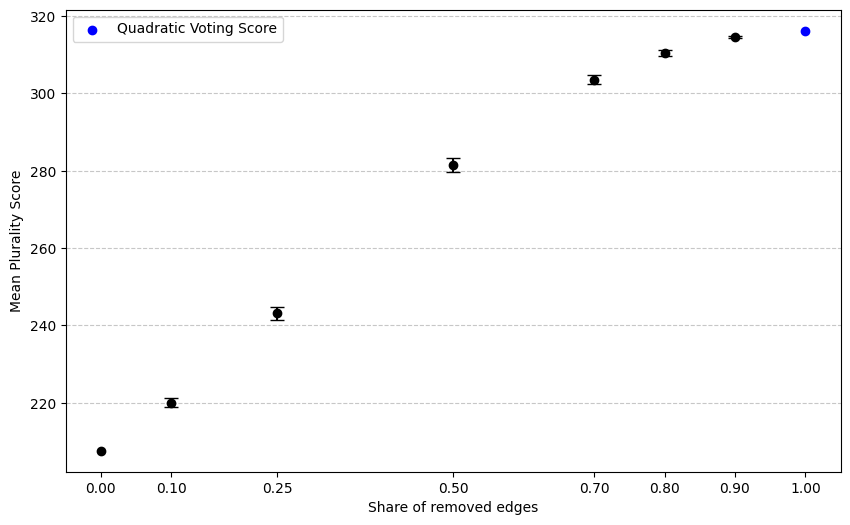

In [30]:
# Calculate mean plurality scores and standard deviations for each share
mean_scores = []
std_devs = []

for edge_share, scores in base_network_results.items():
    mean_score = np.mean(list(scores.values()))
    std_dev = np.std(list(scores.values()))
    mean_scores.append(mean_score)
    std_devs.append(std_dev)

# Plot the mean plurality scores as dots with error bars indicating the standard deviations
plt.figure(figsize=(10, 6))
plt.errorbar(edge_share_values, mean_scores, yerr=std_devs, fmt='o', capsize=5, color='black')

# Include plurality and quadratic score at the extremes
plt.scatter(0, plurality_score, color='black')
plt.scatter(1, quadratic_score, color='blue', label='Quadratic Voting Score')

# Add 0 and 1 to the x-axis ticks
all_edge_share_values = [0] + edge_share_values + [1]

# Label the plot
plt.xlabel('Share of removed edges')
plt.ylabel('Mean Plurality Score')
plt.xticks(all_edge_share_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Save the plot
plt.savefig('plots-and-tables/scores.png')


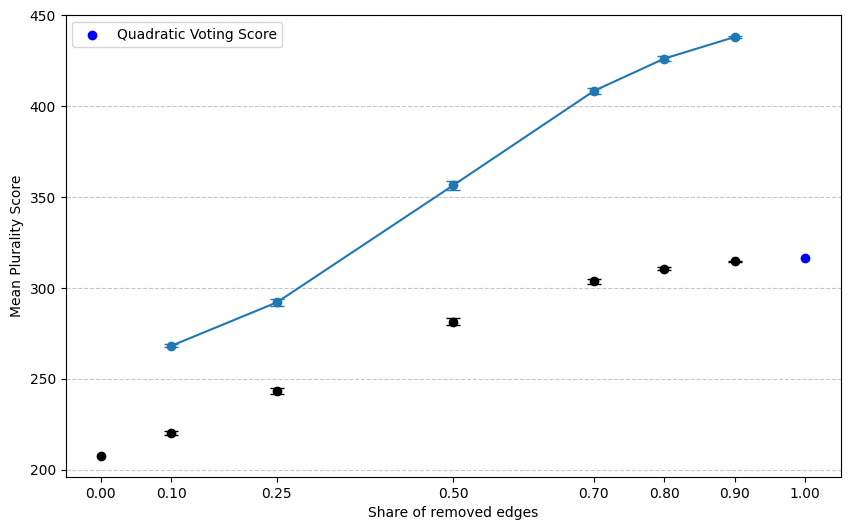

In [31]:
# Calculate mean plurality scores and standard deviations for each share in base_network_results
mean_scores = []
std_devs = []

for edge_share, scores in base_network_results.items():
    mean_score = np.mean(list(scores.values()))
    std_dev = np.std(list(scores.values()))
    mean_scores.append(mean_score)
    std_devs.append(std_dev)

# Plot the mean plurality scores as dots with error bars indicating the standard deviations
plt.figure(figsize=(10, 6))
plt.errorbar(edge_share_values, mean_scores, yerr=std_devs, fmt='o', capsize=5, color='black')

# Include plurality and quadratic score at the extremes
plt.scatter(0, plurality_score, color='black')
plt.scatter(1, quadratic_score, color='blue', label='Quadratic Voting Score')

# Add 0 and 1 to the x-axis ticks
all_edge_share_values = [0] + edge_share_values + [1]

# Label the plot
plt.xlabel('Share of removed edges')
plt.ylabel('Mean Plurality Score')
plt.xticks(all_edge_share_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Plot additional lines for each key in results
for key, data in results.items():
    key_mean_scores = []
    key_std_devs = []
    for edge_share, scores in data.items():
        mean_score = np.mean(list(scores.values()))
        std_dev = np.std(list(scores.values()))
        key_mean_scores.append(mean_score)
        key_std_devs.append(std_dev)
    plt.errorbar(edge_share_values, key_mean_scores, yerr=key_std_devs, fmt='-o', capsize=5, label=key)

# Save the plot
plt.savefig('plots-and-tables/scores.png')


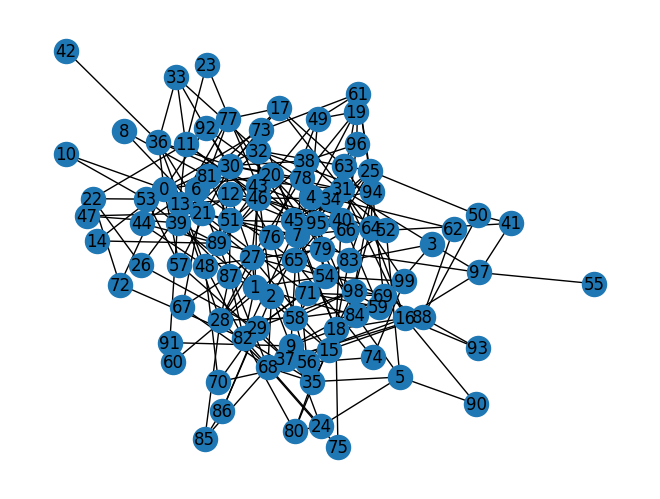

In [32]:
test_network = nx.erdos_renyi_graph(100, 0.05, seed=1)

# Generate positions for the nodes (fixing the positions)
pos = nx.spring_layout(test_network, seed=1)
# Draw the modified network with fixed node positions
nx.draw(er_network, pos=pos, with_labels=True)

In [33]:
exp_num_edges = (p*(n*(n-1)))/2
exp_num_edges

247.5